
--- Infinite Well States ---
  State 0 => E = 4.94
  State 1 => E = 19.74
  State 2 => E = 44.42


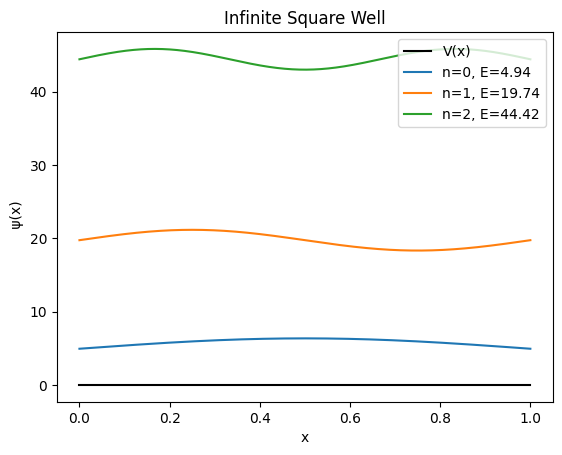


--- Finite Square Well States ---
  State 0 => E = -7.67
  State 1 => E = -1.77


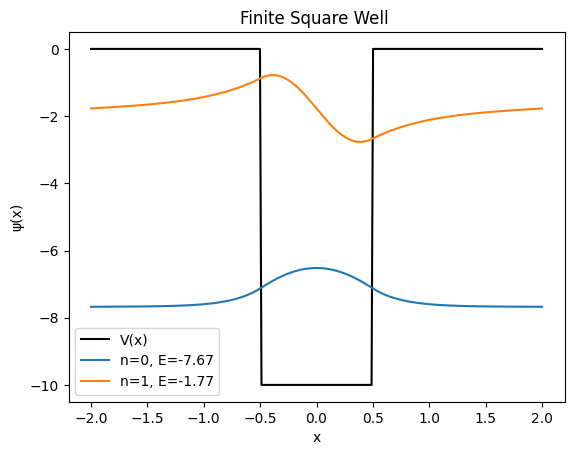


--- Harmonic Oscillator States ---
  State 0 => E = 0.50
  State 1 => E = 1.50
  State 2 => E = 2.50
  State 3 => E = 3.50


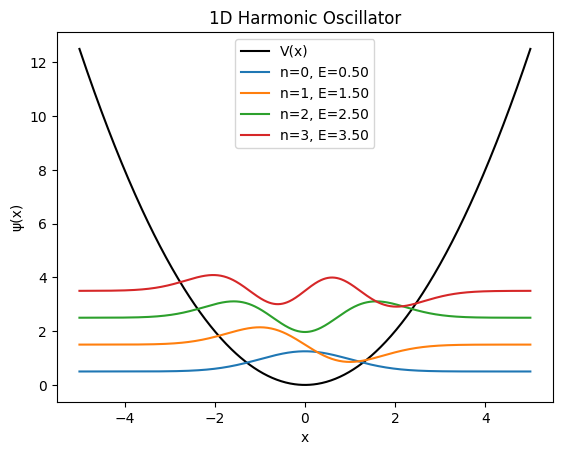

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 1) Numerov integration for 1D TISE
# ---------------------------------------------------------------------
def numerov_integration(x, E, V, mass=1.0, hbar=1.0):

    N = len(x)
    psi = np.zeros(N)
    dx = x[1] - x[0]

    # K(x) = (2m / hbar^2) * [V(x) - E]
    K = (2.0 * mass / (hbar**2)) * (V - E)

    # Numerov recursion constants
    c1 = dx*dx / 12.0

    # Initial wavefunction values
    psi[0] = 0.0
    psi[1] = 1.0e-6  # a small value to avoid a trivial zero solution

    for i in range(1, N - 1):
        K_im1 = K[i - 1]
        K_i   = K[i]
        K_ip1 = K[i + 1]

        f_im1 = 1.0 - c1 * K_im1
        f_i   = 2.0 + 10.0 * c1 * K_i     # 2 + (5/6)*h^2 * K_i = 2 + 10/12 * h^2 * K_i
        f_ip1 = 1.0 - c1 * K_ip1

        psi[i + 1] = (f_i * psi[i] - f_im1 * psi[i - 1]) / f_ip1

    return psi

def boundary_value_at_xmax(x, V, E, mass=1.0, hbar=1.0):
    psi = numerov_integration(x, E, V, mass, hbar)
    return psi[-1]

# ---------------------------------------------------------------------
# 2) Utilities to find multiple bound states
# ---------------------------------------------------------------------
def find_all_brackets(x, V, E_min, E_max, n_points=200, mass=1.0, hbar=1.0):

    E_values = np.linspace(E_min, E_max, n_points)
    boundary_vals = [boundary_value_at_xmax(x, V, E, mass, hbar) for E in E_values]

    brackets = []
    for i in range(n_points - 1):
        if boundary_vals[i] * boundary_vals[i + 1] < 0:
            brackets.append((E_values[i], E_values[i+1]))
    return brackets

def bisection_eigenvalue(x, V, E_left, E_right, mass=1.0, hbar=1.0,
                         tolerance=1e-7, max_iter=100):
    f_left = boundary_value_at_xmax(x, V, E_left,  mass, hbar)
    f_right = boundary_value_at_xmax(x, V, E_right, mass, hbar)
    if f_left * f_right > 0:
        raise ValueError(f"No sign change in [E={E_left:.4f}, {E_right:.4f}]!")

    low, high = E_left, E_right
    for _ in range(max_iter):
        mid = 0.5*(low + high)
        f_mid = boundary_value_at_xmax(x, V, mid, mass, hbar)
        if abs(f_mid) < tolerance:
            psi_mid = numerov_integration(x, mid, V, mass, hbar)
            return mid, psi_mid

        if f_left * f_mid > 0:
            low = mid
            f_left = f_mid
        else:
            high = mid
            f_right = f_mid

    mid = 0.5*(low + high)
    psi_mid = numerov_integration(x, mid, V, mass, hbar)
    return mid, psi_mid

def normalize_wavefunction(x, psi):
    """
    Normalize wavefunction so that ∫|psi|^2 dx = 1.
    """
    norm = np.trapz(np.abs(psi)**2, x)
    if norm < 1e-30:
        return psi
    return psi / np.sqrt(norm)

def find_bound_states(x, V, E_min, E_max, n_points_scan=200, mass=1.0, hbar=1.0):
    brackets = find_all_brackets(x, V, E_min, E_max, n_points_scan, mass, hbar)
    if not brackets:
        return []

    results = []
    for (E_left, E_right) in brackets:
        E_found, psi_unnorm = bisection_eigenvalue(
            x, V, E_left, E_right,
            mass=mass, hbar=hbar
        )
        psi_norm = normalize_wavefunction(x, psi_unnorm)
        results.append((E_found, psi_norm))

    # Sort by ascending energy
    results.sort(key=lambda x: x[0])
    return results

# ---------------------------------------------------------------------
# 3) Demonstration: Three Different Potentials
# ---------------------------------------------------------------------
if __name__ == "__main__":

    # ------------------ A) Infinite Square Well ------------------

    def infinite_well_potential(x, V_out=1e8, left=0, right=1):
        """
        V=0 for left<=x<=right; V_out elsewhere.
        """
        V = np.full_like(x, V_out)
        inside = (x >= left) & (x <= right)
        V[inside] = 0.0
        return V

    # Spatial grid: let's do x in [0, 1] with 1000 points
    x_inf = np.linspace(0, 1, 1000)
    V_inf = infinite_well_potential(x_inf, V_out=1e8, left=0, right=1)

    # We'll guess energies from near 0 up to 50 (arbitrary upper bound).
    states_inf = find_bound_states(x_inf, V_inf, 0.0, 50.0, n_points_scan=300)
    print("\n--- Infinite Well States ---")
    for i, (E_val, psi_val) in enumerate(states_inf):
        print(f"  State {i} => E = {E_val:.2f}")

    plt.figure()
    plt.title("Infinite Square Well")
    plt.plot(x_inf, V_inf, 'k-', label="V(x)")
    for i, (E_val, psi_val) in enumerate(states_inf[:3]):  # plot first 3
        plt.plot(x_inf, psi_val + E_val, label=f"n={i}, E={E_val:.2f}")
    plt.xlabel("x")
    plt.ylabel(" ψ(x)")
    plt.legend()
    plt.show()

    # ------------------ B) Finite Square Well ------------------
    # Depth -10
    def finite_square_well_potential(x, V0=-10.0, a=1.0):
        V = np.zeros_like(x)
        left, right = -a/2, a/2
        inside = (x >= left) & (x <= right)
        V[inside] = V0  # negative => well
        return V

    x_fin = np.linspace(-2.0, 2.0, 300)   # bigger domain so wavefunction decays
    V_fin = finite_square_well_potential(x_fin, V0=-10.0, a=1.0)

    # We'll search energies from ~ -10 up to +0
    states_fin = find_bound_states(x_fin, V_fin, -10.0, 0.0, n_points_scan=300)
    print("\n--- Finite Square Well States ---")
    for i, (E_val, psi_val) in enumerate(states_fin):
        print(f"  State {i} => E = {E_val:.2f}")

    plt.figure()
    plt.title("Finite Square Well ")
    plt.plot(x_fin, V_fin, 'k-', label="V(x)")
    for i, (E_val, psi_val) in enumerate(states_fin):
        plt.plot(x_fin, psi_val + E_val, label=f"n={i}, E={E_val:.2f}")
    plt.xlabel("x")
    plt.ylabel("ψ(x)")
    plt.legend()
    plt.show()

    # ------------------ C) Harmonic Oscillator ------------------
    # V(x) = 0.5 * x^2  (assuming m=1, omega=1, hbar=1)
    def harmonic_oscillator_potential(x):
        return 0.5 * x**2

    # We pick a domain big enough so wavefunctions vanish near edges
    x_harm = np.linspace(-5.0, 5.0, 600)
    V_harm = harmonic_oscillator_potential(x_harm)

    # The ground state is near E=0.5, 1st excited ~1.5, etc.
    # We'll search up to  E=4 to catch several states
    states_harm = find_bound_states(x_harm, V_harm, 0.0, 4.0, n_points_scan=300)
    print("\n--- Harmonic Oscillator States ---")
    for i, (E_val, psi_val) in enumerate(states_harm):
        print(f"  State {i} => E = {E_val:.2f}")

    plt.figure()
    plt.title("1D Harmonic Oscillator")
    plt.plot(x_harm, V_harm, 'k-', label="V(x)")
    for i, (E_val, psi_val) in enumerate(states_harm[:4]):  # Plot first 4
        plt.plot(x_harm, psi_val + E_val, label=f"n={i}, E={E_val:.2f}")
    plt.xlabel("x")
    plt.ylabel("ψ(x)")
    plt.legend()
    plt.show()
